In [178]:
import gpflow
from gpflow.kernels import Combination, RBF
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from copy import deepcopy
gpflow.__version__

'2.0.5'

In [220]:
class Hierarchical(Combination):
    def __init__(self, kern_list, indicator_dims=[1]):
        Combination.__init__(self, kern_list)
        self.indicator_dims = indicator_dims

    def K(self, X, X2=None):
        K = self.kernels[0].K(X, X2)

        if X2 is None:
            X2 = deepcopy(X)

        for i, ind_dim in enumerate(self.indicator_dims):
            print(i, ind_dim)
            indX, indX2 = X[:, ind_dim:ind_dim + 1], X2[:, ind_dim:ind_dim + 1]
            mask = tf.cast(tf.equal(indX, tf.transpose(indX2)), dtype=tf.float64)
            k = self.kernels[i + 1]
            K += mask * k.K(X, X2)
        return K
    
    def K_diag(self, X):
        return tf.linalg.diag_part(self.K(X))

kerns = [RBF(lengthscales=1.5, variance=1.0), RBF(lengthscales=1.5, variance=1.0)]
HierarchicalKern = Hierarchical(kerns)

In [221]:
expression = np.loadtxt('dros_data/kalinka09_mel.csv', delimiter=',', usecols=range(1, 57))
gene_names = np.loadtxt('dros_data/kalinka09_mel.csv', delimiter=',', usecols=[0], dtype=np.str)
replicates, times = np.loadtxt('dros_data/kalinka09_mel_pdata.csv', delimiter=',').T

# normalize data row-wise
expression -= expression.mean(1)[:,np.newaxis]
expression /= expression.std(1)[:,np.newaxis]

gene_index = 12 # hoppefully a typical gene
X = np.hstack((times.reshape(-1,1), replicates.reshape(-1,1)))
Y = expression[gene_index].reshape(-1,1) #must be a column vector for GPy

0 1


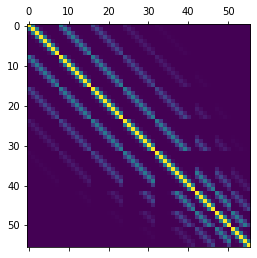

In [222]:
HK = HierarchicalKern.K(X)
plt.matshow(HK)

Text(0, 0.5, 'Y')

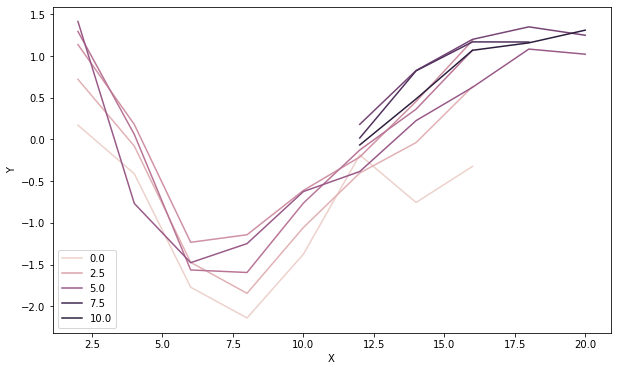

In [217]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(X[:, 0], Y.squeeze(), hue=X[:, 1], ax = ax)
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [214]:
m = gpflow.models.GPR((X, Y), kernel=Hkern)

In [176]:
opt = tf.optimizers.Adam(learning_rate=0.005)
logfs = []

for _ in range(400):
    opt.minimize(m.training_loss, m.trainable_variables)
    logfs.append(m.log_marginal_likelihood().numpy())

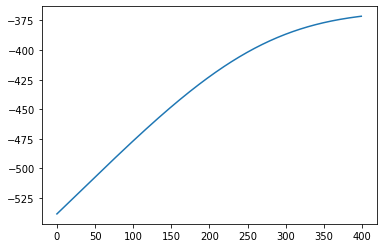

In [177]:
plt.plot(logfs)

In [152]:
nte = 100
Xte = np.hstack((np.tile(np.linspace(0.5, 1.5, nte), T).reshape(-1, 1), indx))
Yte = f(Xte)

mu, sigma = m.predict_y(Xte)

<AxesSubplot:>

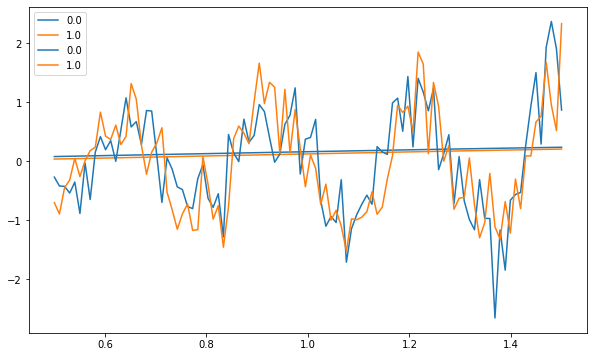

In [154]:
preds = np.hstack((Xte, mu.numpy().reshape(-1, 1)))

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(preds[:, 0], preds[:, 2], hue = preds[:, 1], ax=ax)
sns.lineplot(preds[:, 0], Yte, hue = preds[:, 1], ax=ax)


In [155]:
from gpflow.kernels.multioutput import LinearCoregionalization